<a href="https://colab.research.google.com/github/mkeohane01/GAN-Image-Denoising/blob/denoise-gan-dev/notebooks/train-GAN-denoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

# Download kaggle dataset
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Small dataset
!kaggle datasets download -d rajat95gupta/smartphone-image-denoising-dataset

# Medium dataset
#!kaggle datasets download -d soumikrakshit/smartphone-image-denoising-dataset

Saving kaggle.json to kaggle.json
100% 6.16G/6.16G [02:36<00:00, 43.0MB/s]
100% 6.16G/6.16G [02:36<00:00, 42.3MB/s]


In [2]:
# Unzip the smartphone denoising dataset
!unzip '/content/smartphone-image-denoising-dataset.zip'

Archive:  /content/smartphone-image-denoising-dataset.zip
  inflating: SIDD_Small_sRGB_Only/Data/0001_001_S6_00100_00060_3200_L/GT_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0001_001_S6_00100_00060_3200_L/NOISY_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0002_001_S6_00100_00020_3200_N/GT_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0002_001_S6_00100_00020_3200_N/NOISY_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0003_001_S6_00100_00060_3200_H/GT_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0003_001_S6_00100_00060_3200_H/NOISY_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0004_001_S6_00100_00060_4400_L/GT_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0004_001_S6_00100_00060_4400_L/NOISY_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0005_001_S6_00100_00060_4400_N/GT_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0005_001_S6_00100_00060_4400_N/NOISY_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0006_001

## Imports

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms as T


## Define Model

In [72]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=9, stride=1, padding=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)

        # Adeconvolution layers
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0)

        # conv layers
        self.conv5 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)

        self.conv4 = nn.Conv2d(32, 3, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        input = x
        x_1 = F.relu(self.conv1(x))
        # print(f'x1 size {x_1.shape}')
        x = F.relu(self.conv2(x_1))
        # print(f'x2 size {x.shape}')
        x = F.relu(self.conv3(x))
        # print(f'x3 size {x.shape}')

        x = self.res1(x)
        # print(f'x4 - res1 size {x.shape}')
        x = self.res2(x)
        # print(f'x5 - res2 size {x.shape}')
        x = self.res3(x)
        # print(f'x6 - res3 size {x.shape}')

        # x = F.relu(self.deconv1(x))
        # print(f'x7 - deconv1 size {x.shape}')
        # x = F.relu(self.deconv2(x))
        # print(f'x8 - deconv2 size {x.shape}')

        x = self.conv5(x)
        # print(f'x7 - conv5 size {x.shape}')
        x = self.conv6(x)
        # print(f'x8 - conv6 size {x.shape}')

        # Ensure the sizes match for the skip connection from the first conv layer to the last deconv layer output
        x = x + x_1
        # print(f'x9 - x + x_1 size {x.shape}')

        x = torch.tanh(self.conv4(x))
        # print(f'x10 - conv4 size {x.shape}')
        # Final residual connection from the original input to the final output
        x = x + input
        return torch.sigmoid(x)  # Normalize the output


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = x + residual  # Residual connection
        return x

class Discriminator(nn.Module):
  def __init__(self):
      super(Discriminator, self).__init__()
      self.conv1 = nn.Conv2d(3, 48, kernel_size=4, stride=2, padding=1)
      self.conv2 = nn.Conv2d(48, 96, kernel_size=4, stride=2, padding=1)
      self.conv3 = nn.Conv2d(96, 192, kernel_size=4, stride=2, padding=1)
      self.conv4 = nn.Conv2d(192, 384, kernel_size=4, stride=1, padding=1)
      self.conv5 = nn.Conv2d(384, 1, kernel_size=4, stride=1, padding=1)

  def forward(self, x):
      x = F.leaky_relu(self.conv1(x), 0.2)
      x = F.leaky_relu(self.conv2(x), 0.2)
      x = F.leaky_relu(self.conv3(x), 0.2)
      x = F.leaky_relu(self.conv4(x), 0.2)
      x = torch.sigmoid(self.conv5(x))
      return x

In [76]:
preprocess_transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225]),
    T.Resize((512, 512)),
])

postprocess_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToPILImage(),
])


class ImagePairDataset(Dataset):
    def __init__(self, noisy_image_paths, sharp_image_paths, transform=None):
        """
        Args:
            noisy_image_paths (list of str): Paths to the noisy images.
            sharp_image_paths (list of str): Paths to the sharp, high-definition images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        assert len(noisy_image_paths) == len(sharp_image_paths), "The number of noisy and sharp images must be the same."
        self.noisy_image_paths = noisy_image_paths
        self.sharp_image_paths = sharp_image_paths
        self.transform = transform

    def __len__(self):
        return len(self.noisy_image_paths)

    def __getitem__(self, idx):
        noisy_image = Image.open(self.noisy_image_paths[idx]).convert('RGB')
        sharp_image = Image.open(self.sharp_image_paths[idx]).convert('RGB')

        if self.transform:
            noisy_image = self.transform(noisy_image)
            sharp_image = self.transform(sharp_image)

        return noisy_image, sharp_image


In [80]:

# Function to load image pairs from a folder
def load_image_pairs(folder):
    gt_images = []
    noisy_images = []
    for root, _, files in os.walk(folder):
        for file in files:
            if 'GT' in file:
                gt_images.append(os.path.join(root, file))
            elif 'NOISY' in file:
                noisy_images.append(os.path.join(root, file))
    return gt_images, noisy_images

# Function to train the SRGAN model
def train_denoising_gan(generator, discriminator, train_loader, val_loader, criterion_g, criterion_d, optimizer_g, optimizer_d, num_epochs=10, device='cuda'):
    # Loop through each epoch
    for epoch in range(num_epochs):
        # Set both the generator and discriminator to training mode
        generator.train()
        discriminator.train()

        # Initialize running losses for both generator and discriminator
        running_loss_g = 0.0
        running_loss_d = 0.0

        # Loop through the dataset
        for i, (gt_image, noisy_image) in enumerate(train_loader):
            # Move images to the appropriate device (GPU or CPU)
            gt_image = gt_image.to(device)
            noisy_image = noisy_image.to(device)

            # Zero the gradients for both optimizers
            optimizer_g.zero_grad()
            optimizer_d.zero_grad()

            # Generate super-resolved images from noisy images
            gen_image = generator(noisy_image)
            # print(gen_image.shape)


            # Train the discriminator
            # Discriminator's goal is to distinguish between real (gt_image) and fake (sr_image) images

            # Calculate discriminator loss on real images
            real_output = discriminator(gt_image.detach())
            loss_d_real = criterion_d(real_output, torch.ones_like(real_output))

            # Calculate discriminator loss on fake images
            fake_output = discriminator(gen_image.detach())  # Detach to avoid training G on these labels
            loss_d_fake = criterion_d(fake_output, torch.zeros_like(fake_output))

            # Total discriminator loss
            loss_d = (loss_d_real + loss_d_fake) / 2

            # Backpropagation for discriminator
            loss_d.backward()
            optimizer_d.step()

            # Train the generator
            # Generator's goal is to fool the discriminator into thinking the generated images are real

            # Calculate generator loss
            output = discriminator(gen_image.detach())
            loss_g = criterion_g(output, torch.ones_like(output)) + criterion_g(gen_image, gt_image)

            # Backpropagation for generator
            loss_g.backward()
            optimizer_g.step()

            # Update running losses
            running_loss_g += loss_g.item() * noisy_image.size(0)
            running_loss_d += loss_d.item() * noisy_image.size(0)

            # Print progress
            if i % 4 == 0:
              print(f'Epoch {epoch+1}/{num_epochs}, Batch {i}/{len(train_loader)}, Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}')


        # Calculate average losses for the current epoch
        epoch_loss_g = running_loss_g / len(train_loader.dataset)
        epoch_loss_d = running_loss_d / len(train_loader.dataset)

        # Print losses for the current epoch
        print(f'Train - Epoch {epoch+1}/{num_epochs}, Generator Loss: {epoch_loss_g:.4f}, Discriminator Loss: {epoch_loss_d:.4f}')

        # Compute metrics on validation set
        gen_images = []
        gt_images = []
        input_images = []
        for gt_image, noisy_image in val_loader:
            gt_image = gt_image.to(device)
            noisy_image = noisy_image.to(device)
            gen_image = generator(noisy_image)
            gen_images.append(gen_image.detach())
            input_images.append(noisy_image.detach())
            gt_images.append(gt_image.detach())

        # Compute and print metrics
        psnr = compute_psnr(torch.cat(gen_images), torch.cat(gt_images))
        # ssim = compute_ssim(torch.cat(sr_images), torch.cat(gt_images))
        print(f'Val - PSNR: {psnr:.2f}')

        # Display the 3 images
        gen_image = gen_images[0]
        input_image = input_images[0]
        gt_image = gt_images[0]
        PIL_gen_image = T.ToPILImage()(gen_image[0])
        PIL_input_image = input_image[0]
        PIL_gt_image = gt_image[0]

        display(PIL_input_image)
        display(PIL_gen_image)
        display(PIL_gt_image)

        display(input_image[1])
        display(T.ToPILImage()(gen_image[1]))
        display(gt_image[1])

    return generator, discriminator



# Function to compute PSNR
def compute_psnr(sr_image, gt_image):
    mse = nn.MSELoss()(sr_image, gt_image)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

# Function to compute SSIM
# def compute_ssim(sr_image, gt_image):
#     ssim_val = ssim(sr_image, gt_image, data_range=1.0, win_size=11, win_sigma=1.5, k1=0.01, k2=0.03)
#     return ssim_val.item()

# # Function to compute FID
# def compute_fid(sr_images, gt_images):
#     fid_score = calculate_fid(sr_images, gt_images)
#     return fid_score

In [82]:
# Main function to load data, train model, and compute metrics
def main(train_folder, num_epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # Load image pairs
    gt_images, noisy_images = load_image_pairs(train_folder)
    print(f'Number of training images: {len(gt_images)}')
    print(f'Number of validation images: {len(noisy_images)}')

    # split to train and val
    noisy_train_images, noisy_val_images = train_test_split(noisy_images, test_size=0.2, random_state=42)
    gt_train_images, gt_val_images = train_test_split(gt_images, test_size=0.2, random_state=42)

    # Create dataset
    train_set = ImagePairDataset(noisy_train_images, gt_train_images, transform=preprocess_transform)
    val_set = ImagePairDataset(noisy_val_images, gt_val_images, transform=preprocess_transform)

    # Create data loaders
    train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=2, shuffle=False)

    # Initialize model
    gen = Generator().to(device)
    disc = Discriminator().to(device)
    # print(gen)
    # print(disc)

    # Define loss function and optimizer
    criterion_g = nn.MSELoss() # minimize difference between generated and real images
    criterion_d = nn.BCEWithLogitsLoss()  # For discriminator, to classify between real and fake images

    # Optimizers for generator and discriminator
    optimizer_g = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # Train the model
    generator, discriminator = train_denoising_gan(gen, disc, train_loader, val_loader, criterion_g, criterion_d, optimizer_g, optimizer_d, num_epochs, device=device)

    # Save model
    torch.save(generator.state_dict(), 'generator.pth')
    torch.save(discriminator.state_dict(), 'discriminator.pth')


Using device: cuda
Number of training images: 160
Number of validation images: 160
Epoch 1/2, Batch 0/32, Loss D: 0.7240, Loss G: 2.4825
Epoch 1/2, Batch 4/32, Loss D: 0.6265, Loss G: 1.9400
Epoch 1/2, Batch 8/32, Loss D: 0.5425, Loss G: 2.6504
Epoch 1/2, Batch 12/32, Loss D: 0.5040, Loss G: 2.8394
Epoch 1/2, Batch 16/32, Loss D: 0.5334, Loss G: 2.6410
Epoch 1/2, Batch 20/32, Loss D: 0.5262, Loss G: 2.3011
Epoch 1/2, Batch 24/32, Loss D: 0.5419, Loss G: 1.9839
Epoch 1/2, Batch 28/32, Loss D: 0.5400, Loss G: 1.5598
Train - Epoch 1/2, Generator Loss: 2.3408, Discriminator Loss: 0.5585
Val - PSNR: -1.74


tensor([[[-1.6608, -1.6452, -1.6245,  ..., -0.7425, -0.7549, -0.9311],
         [-1.6398, -1.6028, -1.5878,  ..., -0.7014, -0.6999, -0.8461],
         [-1.5848, -1.5880, -1.5816,  ..., -0.6935, -0.7378, -0.9146],
         ...,
         [-1.5840, -1.4830, -1.3763,  ..., -1.6734, -1.7406, -1.8852],
         [-1.6005, -1.4914, -1.4142,  ..., -1.7473, -1.7568, -1.8057],
         [-1.7664, -1.6911, -1.6463,  ..., -1.8863, -1.8799, -1.8976]],

        [[-1.0799, -0.9899, -0.9880,  ..., -1.1568, -1.1765, -1.2465],
         [-1.0975, -0.9764, -0.9720,  ..., -1.1180, -1.1051, -1.1316],
         [-1.1068, -0.9659, -0.9611,  ..., -1.0971, -1.1504, -1.2036],
         ...,
         [-1.5809, -1.4925, -1.5582,  ..., -1.0575, -1.0801, -1.1252],
         [-1.5762, -1.4786, -1.5099,  ..., -1.0747, -1.0781, -1.0970],
         [-1.6390, -1.5421, -1.5641,  ..., -1.2505, -1.2437, -1.2657]],

        [[-0.8857, -0.6570, -0.6576,  ..., -1.2607, -1.2666, -1.3151],
         [-0.7986, -0.6271, -0.6171,  ..., -1

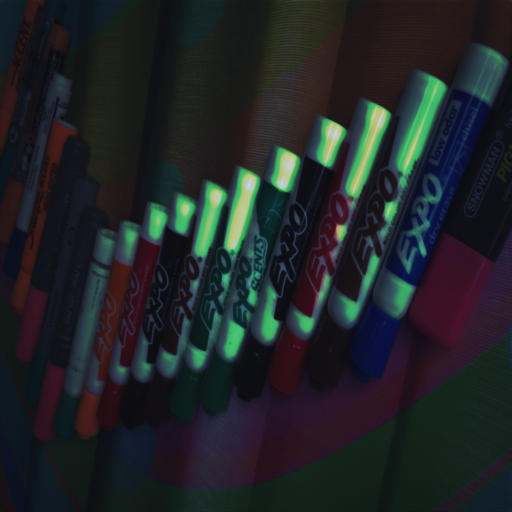

tensor([[[-1.6288, -1.6521, -1.6901,  ..., -0.7259, -0.7824, -0.7665],
         [-1.6364, -1.7636, -1.5947,  ..., -0.6806, -0.7424, -0.7081],
         [-1.5736, -1.6203, -1.5819,  ..., -0.6604, -0.7365, -0.7615],
         ...,
         [-1.5875, -1.5776, -1.4273,  ..., -1.6783, -1.7754, -1.8358],
         [-1.5745, -1.5443, -1.4123,  ..., -1.7603, -1.8102, -1.8051],
         [-1.5122, -1.4750, -1.5212,  ..., -1.8040, -1.7890, -1.7806]],

        [[-0.9779, -0.9694, -0.9654,  ..., -1.1712, -1.1523, -1.1597],
         [-0.9906, -0.9746, -0.9478,  ..., -1.1073, -1.0817, -1.0777],
         [-0.9991, -0.9308, -0.9529,  ..., -1.1061, -1.1690, -1.1629],
         ...,
         [-1.4977, -1.4828, -1.5769,  ..., -1.0666, -1.0848, -1.1023],
         [-1.4796, -1.5048, -1.5468,  ..., -1.0924, -1.0685, -1.0465],
         [-1.4971, -1.5266, -1.5082,  ..., -1.1264, -1.0896, -1.0733]],

        [[-0.6105, -0.6558, -0.6219,  ..., -1.2936, -1.3108, -1.2232],
         [-0.6056, -0.6297, -0.6128,  ..., -1

tensor([[[-1.8563, -1.8428, -1.8115,  ..., -1.7086, -1.7167, -1.7682],
         [-1.7394, -1.7054, -1.7005,  ..., -1.6169, -1.6497, -1.7290],
         [-1.7227, -1.6832, -1.7237,  ..., -1.7218, -1.7296, -1.7800],
         ...,
         [-1.7013, -1.6463, -1.6780,  ..., -1.5076, -1.4946, -1.5180],
         [-1.6691, -1.6108, -1.6660,  ..., -1.5100, -1.5105, -1.5340],
         [-1.6504, -1.6129, -1.6764,  ..., -1.5187, -1.5057, -1.5696]],

        [[-1.8425, -1.8372, -1.8185,  ..., -1.7899, -1.7534, -1.8029],
         [-1.7955, -1.7719, -1.7755,  ..., -1.7372, -1.7409, -1.8062],
         [-1.7790, -1.7392, -1.7722,  ..., -1.7968, -1.7852, -1.8354],
         ...,
         [-1.6398, -1.6449, -1.7393,  ..., -1.5535, -1.5135, -1.5352],
         [-1.6369, -1.6395, -1.7072,  ..., -1.5222, -1.5297, -1.5360],
         [-1.6562, -1.6596, -1.7185,  ..., -1.5344, -1.5198, -1.5689]],

        [[-1.5856, -1.5510, -1.5723,  ..., -1.5347, -1.5420, -1.6050],
         [-1.6243, -1.6020, -1.6278,  ..., -1

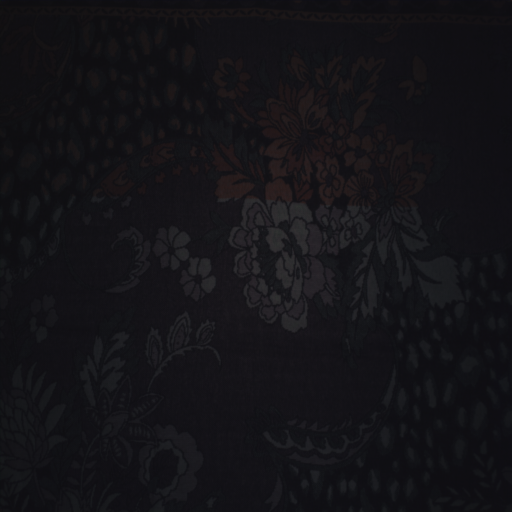

tensor([[[-1.9541, -1.8450, -1.9009,  ..., -1.6104, -1.5063, -1.7167],
         [-1.7487, -1.8066, -1.7878,  ..., -1.6035, -1.6732, -1.8686],
         [-1.7034, -1.6954, -1.7995,  ..., -1.7835, -1.7399, -1.8910],
         ...,
         [-1.6686, -1.6648, -1.7153,  ..., -1.4933, -1.3984, -1.5205],
         [-1.7305, -1.6074, -1.7656,  ..., -1.5199, -1.5233, -1.6982],
         [-1.6102, -1.5363, -1.6896,  ..., -1.6122, -1.5993, -1.7285]],

        [[-1.7010, -1.8058, -1.8537,  ..., -1.7455, -1.7584, -1.8320],
         [-1.7974, -1.7598, -1.8095,  ..., -1.7388, -1.7249, -1.7783],
         [-1.7727, -1.7460, -1.7758,  ..., -1.7519, -1.8128, -1.7519],
         ...,
         [-1.7020, -1.7064, -1.7908,  ..., -1.5806, -1.6203, -1.6221],
         [-1.5662, -1.6342, -1.7146,  ..., -1.6083, -1.6268, -1.6808],
         [-1.5924, -1.7060, -1.7788,  ..., -1.6477, -1.5708, -1.6317]],

        [[-1.6583, -1.5077, -1.5081,  ..., -1.5444, -1.5595, -1.5785],
         [-1.6395, -1.6674, -1.6658,  ..., -1

Epoch 2/2, Batch 0/32, Loss D: 0.5034, Loss G: 3.0008


KeyboardInterrupt: 

In [84]:
# Define variables
train_folder = '/content/SIDD_Small_sRGB_Only/Data'  # Path to the folder containing image pairs
num_epochs = 2

# Call the main function
main(train_folder, num_epochs)

In [85]:
import gc
gc.collect()
torch.cuda.empty_cache()